In [1]:
!pip install xlrd

import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point
from shapely.ops import unary_union
import rasterio
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.transform import from_origin
from scipy.ndimage import distance_transform_edt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)

np.random.seed(42)
pd.options.display.max_columns = 200

# Paths
data_dir = Path("data")
processed = data_dir / "processed"

# Vectors 
boundary = gpd.read_file(processed / "st_thomas_boundary.geojson")
flood_zone = gpd.read_file(processed / "flood_zone_st_thomas_3857.gpkg")
tsunami_zone = gpd.read_file(processed / "tsunami_st_thomas_3857.gpkg")
ghuts = gpd.read_file(processed / "ghuts_st_thomas_3857.gpkg")
landcover = gpd.read_file(processed / "landcover_st_thomas_3857.gpkg")
buildings = gpd.read_file(processed / "buildings_st_thomas_3857.gpkg")

# Rasters 
dem_path = processed / "dem_st_thomas_3857.tif"
slope_path = processed / "slope_degrees_3857.tif"
ghut_dist_raster = processed / "ghut_distance_m_3857.tif" 

target_crs = "EPSG:3857"
for gdf in [boundary, flood_zone, tsunami_zone, ghuts, landcover, buildings]:
    if gdf.crs != target_crs:
        gdf.to_crs(target_crs, inplace=True)

In [2]:
# Flood inventory: positive/negative samples
high_risk_codes = ["VE", "AE","AO","A"]
flood_field = "FLD_ZONE"  
high_risk = flood_zone[flood_zone[flood_field].isin(high_risk_codes)].copy()
high_risk_geom = high_risk.intersection(boundary.unary_union)

def sample_points_in_polygon(gdf, n_points):
    polys = gdf.geometry.values
    xmin, ymin, xmax, ymax = unary_union(polys).bounds
    pts = []
    while len(pts) < n_points:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        p = Point(x, y)
        if any(poly.contains(p) for poly in polys):
            pts.append(p)
    return gpd.GeoDataFrame(geometry=pts, crs=gdf.crs)

n_pos = 400
pos_pts = sample_points_in_polygon(high_risk, n_pos)
pos_pts["label"] = 1

# Safe area = boundary - flood zone
safe_area = boundary.overlay(
    flood_zone,
    how="difference",
    keep_geom_type=True 
)

def sample_points_in_safe_area(gdf, n_points, min_elev=5.0):
    union = unary_union(gdf.geometry.values)
    xmin, ymin, xmax, ymax = union.bounds
    pts = []
    with rasterio.open(dem_path) as src:
        for _ in range(n_points * 10):  # safeguard
            if len(pts) >= n_points:
                break
            x = np.random.uniform(xmin, xmax)
            y = np.random.uniform(ymin, ymax)
            p = Point(x, y)
            if union.contains(p):
                z = list(src.sample([(x, y)]))[0][0]
                if z > min_elev:
                    pts.append(p)
    return gpd.GeoDataFrame(geometry=pts, crs=gdf.crs)

n_neg = n_pos
neg_pts = sample_points_in_safe_area(safe_area, n_neg, min_elev=5.0)
neg_pts["label"] = 0

inventory = pd.concat([pos_pts, neg_pts], ignore_index=True)


print("Inventory size:", inventory.shape)

Inventory size: (800, 2)


Saved plot to images\inventory_points.png


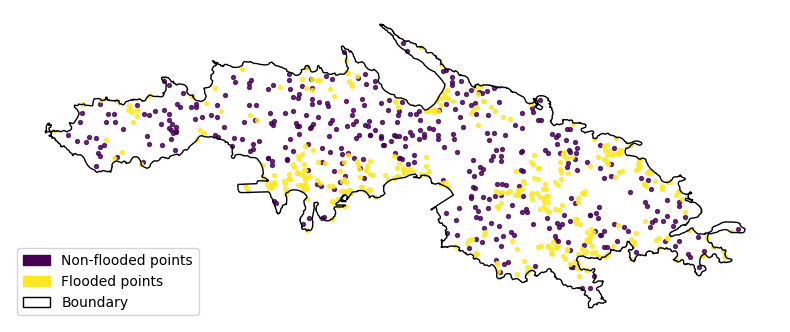

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from pathlib import Path
import geopandas as gpd

images_dir = Path("images")
images_dir.mkdir(exist_ok=True)

# reuse existing boundary/inventory; load boundary if missing
try:
    boundary  # noqa: F821
except NameError:
    boundary = gpd.read_file("data/processed/st_thomas_boundary.geojson")

# inventory must already exist in memory (with 'label' column)
# if not, rerun the sampling step that builds pos_pts/neg_pts and concatenates them
if "inventory" not in globals():
    raise RuntimeError("inventory not found; run the sampling step first")

cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, 3))
neg_color, pos_color = colors[0], colors[2]

pos_gdf = inventory[inventory["label"] == 1]
neg_gdf = inventory[inventory["label"] == 0]

fig, ax = plt.subplots(figsize=(8, 10))
fig.patch.set_alpha(0.0)
ax.set_facecolor("none")

boundary.boundary.plot(ax=ax, color="black", linewidth=1, label="Boundary")
neg_gdf.plot(ax=ax, color=neg_color, markersize=8, alpha=0.8, label="Non-flooded points")
pos_gdf.plot(ax=ax, color=pos_color, markersize=8, alpha=0.8, label="Flooded points")

ax.set_axis_off()
legend_patches = [
    mpatches.Patch(color=neg_color, label="Non-flooded points"),
    mpatches.Patch(color=pos_color, label="Flooded points"),
    mpatches.Patch(facecolor="none", edgecolor="black", label="Boundary"),
]
ax.legend(handles=legend_patches, loc="lower left")

plt.tight_layout()
out_path = images_dir / "inventory_points.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", transparent=True)
print(f"Saved plot to {out_path}")

In [4]:
# Feature extraction helpers
def sample_raster_values(points_gdf, raster_path, col_name):
    with rasterio.open(raster_path) as src:
        coords = [(geom.x, geom.y) for geom in points_gdf.geometry]
        values = [val[0] for val in src.sample(coords)]
    points_gdf[col_name] = values
    return points_gdf

# DEM & slope
inventory = sample_raster_values(inventory, dem_path, "elev")
inventory = sample_raster_values(inventory, slope_path, "slope")

# Tsunami zone flag
inventory["in_tsunami"] = inventory.geometry.apply(
    lambda p: tsunami_zone.contains(p).any()
).astype(int)

# Ghut distance
use_raster_dist = True
if use_raster_dist:
    inventory = sample_raster_values(inventory, ghut_dist_raster, "dist_ghut")
else:
    inventory["dist_ghut"] = inventory.geometry.apply(lambda p: ghuts.distance(p).min())

# Land cover
lc_field = "class" 
landcover = landcover.rename(columns={lc_field: "land_class"})
inventory = gpd.sjoin(inventory, landcover[["land_class", "geometry"]], how="left", predicate="within")
inventory = pd.get_dummies(inventory, columns=["land_class"], prefix="lc")


Saved plot to images\correlation_heatmap.png


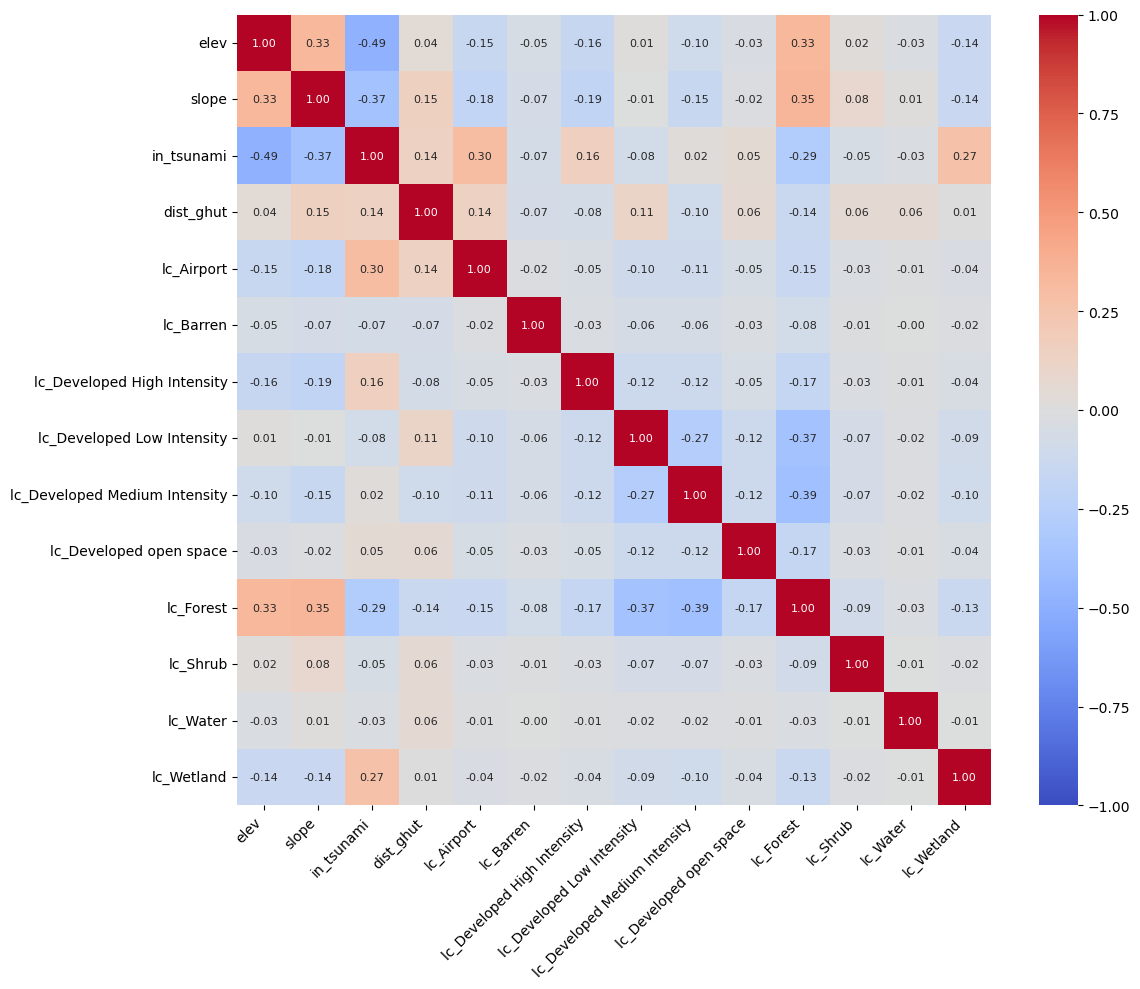

In [5]:
import os
from pathlib import Path

images_dir = Path("images")
images_dir.mkdir(exist_ok=True)

# ML: Random Forest
feature_cols = [c for c in inventory.columns 
                if c not in ["geometry", "label", "index_right",
                             "rain_annual_mean", "rain_max_month","lc_Rangeland"]]
X = inventory[feature_cols].values
y = inventory["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Convert training set to DataFrame for correlation analysis
train_df = pd.DataFrame(X_train, columns=feature_cols)

# Plot correlation heatmap WITH numeric values
plt.figure(figsize=(12, 10))
sns.heatmap(
    train_df.corr(),
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

out_path = images_dir / "correlation_heatmap.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {out_path}")

plt.show()

In [6]:
rf_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42,
        class_weight="balanced",
    ),
)
rf_pipe.fit(X_train, y_train)
print("Train acc:", rf_pipe.score(X_train, y_train))
print("Test acc:", rf_pipe.score(X_test, y_test))

scores = cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring="roc_auc")
print("CV AUC mean:", scores.mean(), "std:", scores.std())

pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42, class_weight="balanced")
)
param_grid = {
    "randomforestclassifier__n_estimators": [50, 75, 100, 150],
    "randomforestclassifier__max_depth": [8, 10, 12, None],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 3, 5],
}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

Train acc: 0.9196428571428571
Test acc: 0.85
CV AUC mean: 0.9424107142857142 std: 0.022300099138684734
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 150}
Best CV AUC: 0.9459183673469388


Accuracy: 0.85
ROC-AUC: 0.9396527777777778
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       120
           1       0.87      0.82      0.85       120

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240

Saved plot to images\roc.png


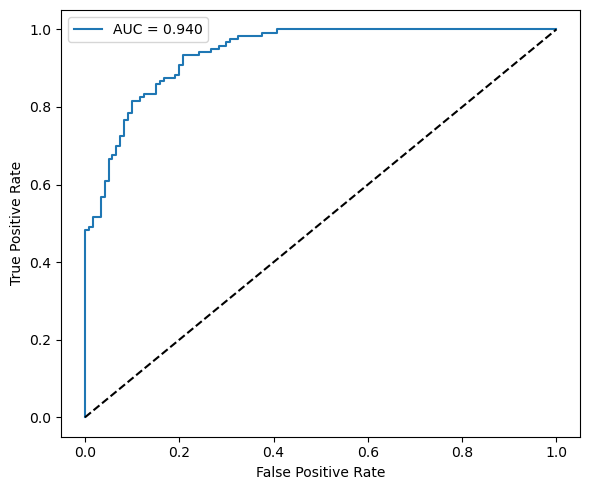

In [7]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
out_path = images_dir / "roc.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", transparent=True)
print(f"Saved plot to {out_path}")

,Feature,Importance
0,elev,0.409406
1,slope,0.193573
3,dist_ghut,0.190259
2,in_tsunami,0.138606
10,lc_Forest,0.026211
7,lc_Developed Low Intensity,0.006549
13,lc_Wetland,0.006090
8,lc_Developed Medium Intensity,0.005824
4,lc_Airport,0.005724
6,lc_Developed High Intensity,0.005118


Saved plot to images\feature_importance.png


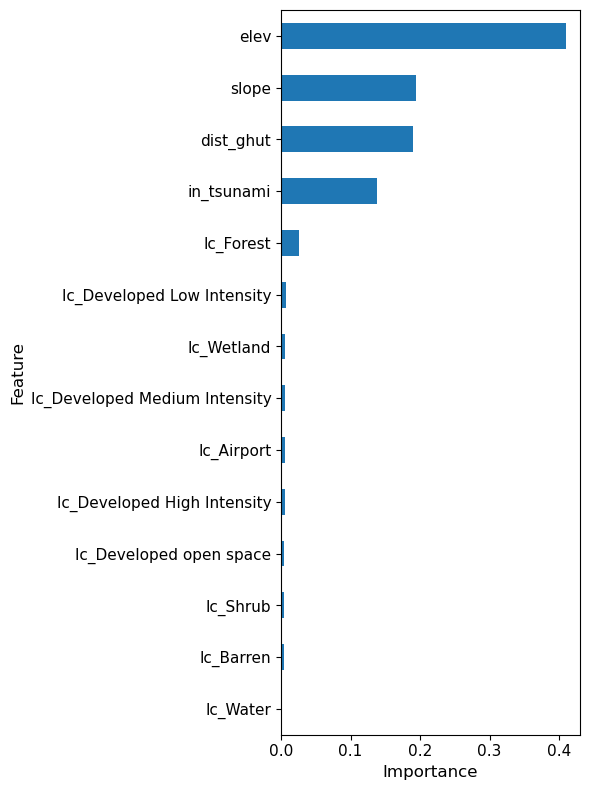

In [8]:
rf_model = best_model.named_steps["randomforestclassifier"]
importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

display(importance.head(15))

# Create chart
importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf_model.feature_importances_
}).sort_values("Importance", ascending=False)

ax = importance.sort_values("Importance", ascending=True).plot.barh(
    x="Feature",
    y="Importance",
    figsize=(6, 8),
    legend=False  # no legend by default
)

# Increase font sizes
ax.set_xlabel("Importance", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.tick_params(axis="both", labelsize=11)

# If you do need a legend (e.g., single patch), add it and set fontsize:
# ax.legend(fontsize=12)

plt.tight_layout()
out_path = images_dir / "feature_importance.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", transparent=True)
print(f"Saved plot to {out_path}")

Grid points: 31862
Saved susceptibility raster: data\processed\st_thomas_flood_susceptibility.tif
Non-nan cells: 31862


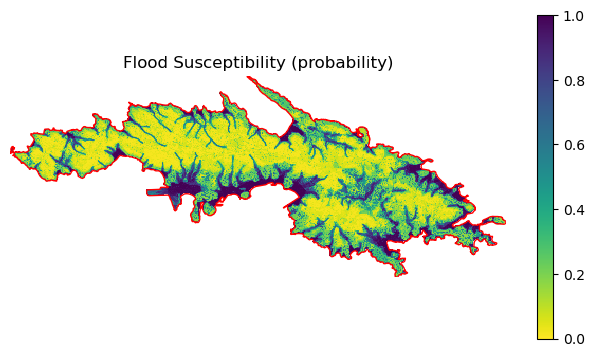

In [9]:
# Predict to grid and write GeoTIFF (rain fields removed)
res = 50  # meters
minx, miny, maxx, maxy = boundary.total_bounds
xs = np.arange(minx, maxx, res)
ys = np.arange(miny, maxy, res)

grid_pts = []
for x in xs:
    for y in ys:
        p = Point(x + res/2, y + res/2)
        if boundary.geometry.unary_union.contains(p):
            grid_pts.append(p)

grid = gpd.GeoDataFrame(geometry=grid_pts, crs=boundary.crs)
print("Grid points:", len(grid))

grid = sample_raster_values(grid, dem_path, "elev")
grid = sample_raster_values(grid, slope_path, "slope")

if use_raster_dist:
    grid = sample_raster_values(grid, ghut_dist_raster, "dist_ghut")
else:
    grid["dist_ghut"] = grid.geometry.apply(lambda p: ghuts.distance(p).min())

grid = gpd.sjoin(grid, landcover[["land_class", "geometry"]], how="left", predicate="within")
grid = pd.get_dummies(grid, columns=["land_class"], prefix="lc")

# Drop rain fields entirely

grid["in_tsunami"] = grid.geometry.apply(
    lambda p: tsunami_zone.contains(p).any()
).astype(int)

# Ensure all feature columns are present
for c in feature_cols:
    if c not in grid.columns and c not in ["geometry"]:
        grid[c] = 0

X_grid = grid[feature_cols].values
grid["suscept_prob"] = best_model.predict_proba(X_grid)[:, 1]

n_cols = len(xs)
n_rows = len(ys)
transform = from_origin(minx, maxy, res, res)
suscept_arr = np.full((n_rows, n_cols), np.nan, dtype="float32")

for idx, geom in enumerate(grid.geometry):
    x, y = geom.x, geom.y
    col = int((x - minx) // res)
    row = int((maxy - y) // res)
    suscept_arr[row, col] = grid.iloc[idx]["suscept_prob"]

out_path = processed / "st_thomas_flood_susceptibility.tif"
with rasterio.open(
    out_path,
    "w",
    driver="GTiff",
    height=n_rows,
    width=n_cols,
    count=1,
    dtype="float32",
    crs=boundary.crs,
    transform=transform,
    nodata=np.nan,
) as dst:
    dst.write(suscept_arr, 1)

print("Saved susceptibility raster:", out_path)

# Preview susceptibility raster
valid = np.count_nonzero(~np.isnan(suscept_arr))
print("Non-nan cells:", valid)

suscept_masked = np.ma.masked_invalid(suscept_arr)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(
    suscept_masked,
    extent=(minx, maxx, miny, maxy),
    origin="upper",
    cmap="viridis_r",
    vmin=0,
    vmax=1,
    interpolation="nearest",
)
boundary.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Flood Susceptibility (probability)")
ax.set_axis_off()
plt.colorbar(img, ax=ax, shrink=0.7)
plt.show()


Saved plot to images\flood_susceptibility.png


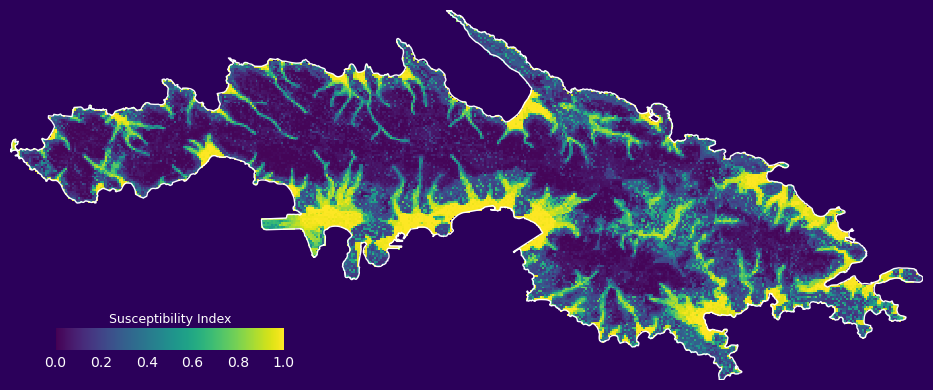

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Mask NaNs
suscept_masked = np.ma.masked_invalid(suscept_arr)

fig, ax = plt.subplots(figsize=(10, 4))

# Dark purple background
fig.patch.set_facecolor("#2b005a")
ax.set_facecolor("#2b005a")

img = ax.imshow(
    suscept_masked,
    extent=(minx, maxx, miny, maxy),
    origin="upper",
    cmap="viridis",
    vmin=0,
    vmax=1,
    interpolation="nearest",
)

# Optional boundary overlay
boundary.boundary.plot(ax=ax, color="white", linewidth=1)

# Horizontal colorbar inset (bottom-left)
cax = ax.inset_axes([0.05, 0.08, 0.25, 0.06])  # [x, y, width, height] in axis fraction
cbar = fig.colorbar(img, cax=cax, orientation="horizontal")
cbar.ax.set_title("Susceptibility Index", fontsize=9, pad=4, color="white")
cbar.outline.set_linewidth(0)
cbar.ax.tick_params(size=0)
cbar.ax.xaxis.set_tick_params(pad=4, colors="white")

ax.set_axis_off()
plt.tight_layout()
out_path = images_dir / "flood_susceptibility.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {out_path}")

In [11]:
!pip install rasterio
!pip install rasterstats
!pip install hvplot
!pip install folium matplotlib mapclassify

import hvplot.pandas  # registers .hvplot accessor on DataFrame / GeoDataFrame
import holoviews as hv
hv.extension("bokeh")  # or "bokeh", "plotly" depending on what you use

import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from shapely import make_valid
import rasterio
from rasterstats import zonal_stats  # ensure installed
import hvplot.pandas  # for interactive maps 

In [12]:
# Paths and base settings
data_dir = Path("data")
processed = data_dir / "processed"

buildings_path = processed / "buildings_st_thomas_3857.gpkg"
parcels_path   = processed / "parcel_value_st_thomas_3857.gpkg"
suscept_raster = processed / "st_thomas_flood_susceptibility.tif"

boundary = gpd.read_file(processed / "st_thomas_boundary.geojson")
target_crs = "EPSG:3857"

# Load and clean vector data
bld = gpd.read_file(buildings_path).to_crs(target_crs)
parcels = gpd.read_file(parcels_path).to_crs(target_crs)

# Ensure valid geometries and remove empty ones
bld["geometry"] = bld.geometry.apply(make_valid)
parcels["geometry"] = parcels.geometry.apply(make_valid)
bld = bld[~bld.geometry.is_empty]
parcels = parcels[~parcels.geometry.is_empty]

In [13]:
# Select residential parcels by zoning code
res_codes = ["R-1", "R-2", "R-3", "R-4", "R-5"]
parcels_res = parcels[parcels["DPNR_ZONE"].isin(res_codes)].copy()

# Ensure land value field is numeric
parcels_res["Land_Value"] = pd.to_numeric(parcels_res["Land_Value"], errors="coerce")

# Compute parcel area (m²) and land value per m²
parcels_res["parcel_area_m2"] = parcels_res.geometry.area  # geometry is parcel footprint after sjoin_nearest
parcels_res["land_value_per_m2"] = parcels_res["Land_Value"] / parcels_res["parcel_area_m2"]

# Spatial join: attach zoning + land value to buildings
bld_res = gpd.sjoin(
    bld,
    parcels_res[["DPNR_ZONE", "Land_Value", "geometry","land_value_per_m2"]],
    how="inner",
    predicate="intersects",
)

# Remove duplicate footprints caused by intersecting multiple parcels
bld_res = (
    bld_res
    .drop(columns=["index_right"])
    .drop_duplicates(subset="geometry")
    .reset_index(drop=True)
)

print("Residential buildings:", len(bld_res))

# Compute zonal statistics: median flood susceptibility per building
with rasterio.open(suscept_raster) as src:
    transform = src.transform
    nodata = src.nodata

stats = zonal_stats(
    bld_res,
    suscept_raster,
    stats=["median"],
    affine=transform,
    nodata=nodata,
    all_touched=True,
)

bld_res["median_suscept"] = [s["median"] for s in stats]

# Classification bins/labels (0–1 range)
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["Very Low", "Low", "Moderate", "High", "Very High"]

# Assign class
bld_res["suscept_class"] = pd.cut(
    bld_res["median_suscept"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Remove buildings that fall in raster NoData regions
bld_res = bld_res.dropna(subset=["median_suscept"])
bld_res.head()

Residential buildings: 14074


,Class,Confidence,ORIG_OID,STATUS,Shape__Area,Shape__Length,geometry,DPNR_ZONE,Land_Value,land_value_per_m2,median_suscept,suscept_class
0,,0.0,0,0,447.396912,128.678690,"POLYGON ((-7227123.248 2076346.558, -7227121.4...",R-3,0,0.000000,0.956010,Very High
1,,0.0,0,0,87.480919,38.886598,"POLYGON ((-7226351.113 2076451.748, -7226360.5...",R-1,111400,21.377060,0.053907,Very Low
2,,0.0,0,0,305.931160,88.378517,"POLYGON ((-7226367.053 2076483.508, -7226373.7...",R-1,264600,71.596789,0.042051,Very Low
3,,0.0,0,0,57.737015,30.402170,"POLYGON ((-7226361.397 2076463.862, -7226368.2...",R-1,264600,71.596789,0.075801,Very Low
4,,0.0,0,0,260.566460,66.460525,"POLYGON ((-7226385.420 2076522.375, -7226369.8...",R-1,264600,71.596789,0.055169,Very Low


Saved plot to images\residence_susceptability.png


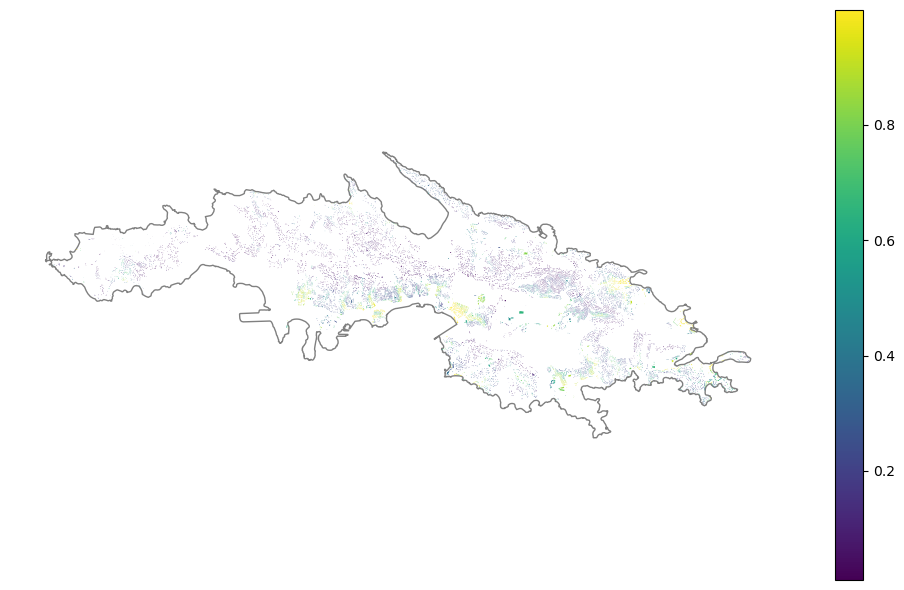

In [14]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 6))  # adjusted size

# Plot the city limits (boundary in white)
boundary.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=1)

# Plot the median NDVI (median_suscept) with white building outlines
bld_res.plot(column="median_suscept", legend=True, ax=ax, cmap="viridis",
             edgecolor="none", linewidth=0.1)

# Format
ax.set_axis_off()
plt.tight_layout()
out_path = images_dir / "residence_susceptability.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {out_path}")

In [15]:
# Preview residential land value table 
# Keep only buildings that have valid land value info
bld_val = bld_res.dropna(subset=["Land_Value"])
bld_val = bld_val[bld_val["Land_Value"] > 0].copy()

# Select key columns to inspect
preview_cols = [
    "Land_Value",       # parcel land value (USD)
    "land_value_per_m2",# land value per m² (USD/m²)
    "parcel_area_m2",
    "DPNR_ZONE",        # zoning category
    "median_suscept",   # median flood susceptibility
    "suscept_class",    # classified susceptibility level
]

bld_val.head()

,Class,Confidence,ORIG_OID,STATUS,Shape__Area,Shape__Length,geometry,DPNR_ZONE,Land_Value,land_value_per_m2,median_suscept,suscept_class
1,,0.0,0,0,87.480919,38.886598,"POLYGON ((-7226351.113 2076451.748, -7226360.5...",R-1,111400,21.377060,0.053907,Very Low
2,,0.0,0,0,305.931160,88.378517,"POLYGON ((-7226367.053 2076483.508, -7226373.7...",R-1,264600,71.596789,0.042051,Very Low
3,,0.0,0,0,57.737015,30.402170,"POLYGON ((-7226361.397 2076463.862, -7226368.2...",R-1,264600,71.596789,0.075801,Very Low
4,,0.0,0,0,260.566460,66.460525,"POLYGON ((-7226385.420 2076522.375, -7226369.8...",R-1,264600,71.596789,0.055169,Very Low
6,,0.0,0,0,31.493248,22.624998,"POLYGON ((-7227102.712 2076239.331, -7227107.1...",R-1,118300,61.574446,0.296520,Low


In [16]:
import pathlib
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import altair as alt
import osmnx as ox

import geopandas as gpd
from shapely.validation import make_valid 

# Load study area boundary and project to analysis CRS
boundary_fp = processed / "st_thomas_boundary.geojson"

# Read raw boundary (whatever CRS the file is in)
boundary = gpd.read_file(boundary_fp)

# Project to target_crs (e.g. EPSG:3857)
boundary = boundary.to_crs(target_crs)

# Fix invalid geometries 
boundary["geometry"] = boundary.geometry.apply(make_valid)

# Drop empty / null geometries
boundary = boundary[
    boundary.geometry.notnull() & ~boundary.geometry.is_empty
]

# Dissolve all parts into a single study-area polygon
boundary["dissolve_id"] = 1  # same value for all rows
boundary_dissolved = boundary.dissolve(by="dissolve_id")

# Single Polygon (or MultiPolygon) object
boundary_union = boundary_dissolved.geometry.iloc[0]
boundary_single = gpd.GeoDataFrame(
    geometry=[boundary_union],
    crs=target_crs
)

print("Boundary rows (raw):", len(boundary))
print("Boundary union type:", boundary_union.geom_type)

Boundary rows (raw): 1
Boundary union type: Polygon


In [17]:
from shapely import make_valid

# Load and project
shelters = gpd.read_file(data_dir / "Shelter.geojson").to_crs(target_crs)
shelters["geometry"] = shelters.geometry.apply(make_valid)
shelters = shelters[~shelters.geometry.is_empty]

# Clip to boundary (boundary/ boundary_union already in target_crs)
shelters = gpd.clip(shelters, boundary_union)
shelters = shelters[~shelters.geometry.is_empty]

# IDs/names
if "shelter_id" not in shelters.columns:
    shelters["shelter_id"] = shelters.index.astype(str)
if "name" not in shelters.columns:
    shelters["name"] = shelters.index.astype(str)

print("Shelters after clip:", shelters.shape)
shelters.head()

Shelters after clip: (6, 8)


,FID,Name,Latitude,Longitude,Island,geometry,shelter_id,name
5,5,Bertha B. Boschulte School,18.317206,-64.891119,St.Thomas,POINT (-7223646.324 2074710.573),5,5
0,0,Sugar Estate Head Start Center,18.339801,-64.920562,St.Thomas,POINT (-7226923.904 2077360.258),0,0
1,1,Community Health Clinic at Schneider,18.340168,-64.914869,St.Thomas,POINT (-7226290.162 2077403.298),1,1
4,4,Charlotte Amalie High School Auditorium,18.341186,-64.919949,St.Thomas,POINT (-7226855.665 2077522.686),4,4
2,2,Lockhart Elementary,18.341674,-64.916455,St.Thomas,POINT (-7226466.715 2077579.917),2,2


In [18]:
!pip install pandana 

import pandana as pdna
from pandana.loaders import osm
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point

In [19]:
# Build Pandana network from St Thomas bbox
# Reproject boundary to WGS84 and get bounding box
boundary_wgs = gpd.GeoSeries([boundary_union], crs=target_crs).to_crs("EPSG:4326")
lng_min, lat_min, lng_max, lat_max = boundary_wgs.total_bounds
print("BBox (WGS84):", lat_min, lng_min, lat_max, lng_max)

# Build WALK network with Pandana
net = osm.pdna_network_from_bbox(
    lat_min, lng_min, lat_max, lng_max,
    network_type="walk"
)
print("Pandana network nodes:", len(net.nodes_df), "edges:", len(net.edges_df))

# Prepare shelters as POIs in WGS84
shelters_wgs = shelters.to_crs("EPSG:4326").copy()

if "shelter_id" not in shelters_wgs.columns:
    shelters_wgs["shelter_id"] = shelters_wgs.index.astype(str)
if "name" not in shelters_wgs.columns:
    shelters_wgs["name"] = shelters_wgs["shelter_id"]

max_distance = 4000  # meters
num_pois = 1         # nearest shelter only

net.set_pois(
    "shelter",
    max_distance,
    num_pois,
    shelters_wgs.geometry.x.values,
    shelters_wgs.geometry.y.values
)
print("Shelter POIs registered.")

BBox (WGS84): 18.302428399999997 -65.0421288 18.3833342 -64.8317848
Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](18.30242840,-65.04212880,18.38333420,-64.83178480);>;);out;'}"
Downloaded 3,672.5KB from www.overpass-api.de in 0.97 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.04 seconds
Returning OSM data with 31,129 nodes and 3,571 ways...
Edge node pairs completed. Took 1.82 seconds
Returning processed graph with 3,774 nodes and 4,605 edges...
Completed OSM data download and Pandana node and edge table creation in 3.23 seconds
Pandana network nodes: 3774 edges: 4647
Shelter POIs registered.


In [20]:
# Compute distance from each network node to nearest shelter
access = net.nearest_pois(
    distance=max_distance,
    category="shelter",
    num_pois=num_pois
)
print("Access head:")
display(access.head())

# Merge node coordinates with distances
nodes = pd.merge(net.nodes_df, access, left_index=True, right_index=True)
nodes.rename(columns={1: "dist_to_shelter_m"}, inplace=True)

# Make GeoDataFrame in WGS84
nodes_gdf = gpd.GeoDataFrame(
    nodes,
    geometry=gpd.points_from_xy(nodes["x"], nodes["y"]),
    crs="EPSG:4326"
)

# Reproject nodes to target_crs (EPSG:3857) for distance calc with buildings
nodes_gdf_3857 = nodes_gdf.to_crs(target_crs).copy()

print("Nodes with distance to shelter (head):")
display(nodes_gdf_3857.head())


Access head:


,1
id,
249647430,3467.790039
249900105,4000.000000
249900121,4000.000000
249900132,4000.000000
249900149,4000.000000


Nodes with distance to shelter (head):


,x,y,dist_to_shelter_m,geometry
id,,,,
249647430,-64.952149,18.334457,3467.790039,POINT (-7230440.119 2076733.484)
249900105,-64.852174,18.332734,4000.000000,POINT (-7219310.975 2076531.518)
249900121,-64.855298,18.335413,4000.000000,POINT (-7219658.715 2076845.656)
249900132,-64.857668,18.336584,4000.000000,POINT (-7219922.554 2076982.995)
249900149,-64.863064,18.340887,4000.000000,POINT (-7220523.289 2077487.608)


In [21]:
# Create centroids for residential buildings (keep all attributes)
bld_centroids = bld_val.copy()
bld_centroids["geometry"] = bld_centroids.geometry.centroid

# Ensure building ID exists
if "bld_id" not in bld_centroids.columns:
    bld_centroids["bld_id"] = bld_centroids.index.astype(str)

print("Preview centroid table:")
display(
    bld_centroids[
        [
            "bld_id",
            "Land_Value",
            "land_value_per_m2",
            "DPNR_ZONE",
            "median_suscept",
            "suscept_class",
            "geometry",
        ]
    ].head()
)


Preview centroid table:


,bld_id,Land_Value,land_value_per_m2,DPNR_ZONE,median_suscept,suscept_class,geometry
1,1,111400,21.377060,R-1,0.053907,Very Low,POINT (-7226358.391 2076449.909)
2,2,264600,71.596789,R-1,0.042051,Very Low,POINT (-7226372.050 2076483.505)
3,3,264600,71.596789,R-1,0.075801,Very Low,POINT (-7226366.972 2076464.853)
4,4,264600,71.596789,R-1,0.055169,Very Low,POINT (-7226378.245 2076514.560)
6,6,118300,61.574446,R-1,0.296520,Low,POINT (-7227102.998 2076243.592)


In [22]:
# Simple nearest-node function 
def nearest_node_id(point):
    """
    Return the ID of the nearest Pandana/network node for a given Point.
    Both buildings and nodes are in target_crs (e.g., EPSG:3857).
    This version computes distance to ALL nodes (simple but robust).
    """
    if point is None or point.is_empty:
        return None

    # Distance from this building centroid to all nodes
    dists = nodes_gdf_3857.geometry.distance(point)

    # If all NaN 
    if dists.isna().all():
        return None

    # Return index label of closest node 
    return dists.idxmin()

# Apply to every centroid
bld_centroids["nearest_node"] = bld_centroids.geometry.apply(nearest_node_id)

print("Preview nearest_node values:")
display(bld_centroids[["bld_id", "nearest_node"]].head())


Preview nearest_node values:


,bld_id,nearest_node
1,1,280447904
2,2,280447904
3,3,280447904
4,4,280447904
6,6,251720799


In [23]:
# Attach walking distance from nodes to buildings
bld_with_access = bld_centroids.merge(
    nodes_gdf_3857[["dist_to_shelter_m"]],
    left_on="nearest_node",
    right_index=True,
    how="left",
)

print("Buildings with walking distance to nearest shelter (head):")
display(bld_with_access[["bld_id", "nearest_node", "dist_to_shelter_m"]].head())


Buildings with walking distance to nearest shelter (head):


,bld_id,nearest_node,dist_to_shelter_m
1,1,280447904,1767.099976
2,2,280447904,1767.099976
3,3,280447904,1767.099976
4,4,280447904,1767.099976
6,6,251720799,1313.702026


Saved plot to images\walking_distance_to_nearest_shelter.png


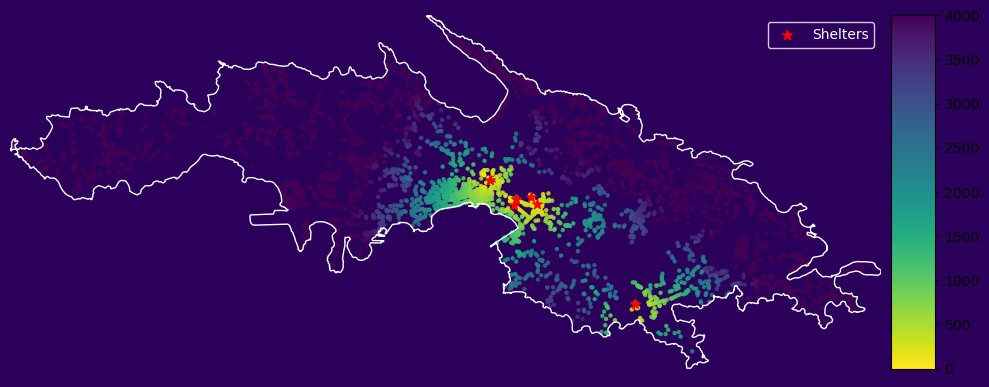

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Align CRS
boundary_3857 = boundary.to_crs(target_crs)
shelters_3857 = shelters.to_crs(target_crs).copy()

# Fix boundary and build a union
boundary_union = boundary_3857.buffer(0).unary_union

# Clip nodes to boundary
nodes_clipped = nodes_gdf_3857[
    nodes_gdf_3857.geometry.within(boundary_union)
].copy()

def plot_walking_distance_to_shelter(
    nodes_gdf_3857,
    shelters_3857,
    column="dist_to_shelter_m"
):
    fig, ax = plt.subplots(figsize=(10, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Plot clipped nodes colored by walking distance
    plot_kwargs = {"s": 10, "alpha": 0.9, "cmap": "viridis_r", "edgecolor": "none"}
    scatter = nodes_gdf_3857.plot(
        ax=ax,
        cax=cax,
        column=column,
        legend=True,
        **plot_kwargs
    )

    # Add shelters as red stars
    shelters_3857.plot(ax=ax, color="red", markersize=50, marker="*", label="Shelters")

    # Add boundary
    boundary_3857.boundary.plot(ax=ax, edgecolor="white", linewidth=1)

    # Formatting
    fig.patch.set_facecolor("#2b005a")
    ax.set_facecolor("#2b005a")
    xmin, ymin, xmax, ymax = boundary_3857.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_axis_off()

    # Legend styling
    leg = ax.legend()
    if leg:
        for txt in leg.get_texts():
            txt.set_color("white")
        leg.get_frame().set_facecolor("#2b005a")
        leg.get_frame().set_edgecolor("white")

    plt.tight_layout()
    return ax

# Example usage:
ax = plot_walking_distance_to_shelter(
    nodes_gdf_3857=nodes_clipped,
    shelters_3857=shelters_3857,
    column="dist_to_shelter_m"
)

out_path = images_dir / "walking_distance_to_nearest_shelter.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {out_path}")

In [25]:
import altair as alt

# Palette for susceptibility
suscept_order = ["Very Low", "Low", "Moderate", "High", "Very High"]
colors = ["#2ca25f", "#99d8c9", "#fed98e", "#f46d43", "#bd0026"]  # match legend

alt.data_transformers.disable_max_rows()

# Drop rows missing key fields
df_raw = bld_with_access.dropna(subset=["land_value_per_m2", "dist_to_shelter_m", "suscept_class"]).copy()

# Remove extreme outliers (99th percentile cap)
upper_cap = df_raw["land_value_per_m2"].quantile(0.99)
df = df_raw[df_raw["land_value_per_m2"] <= upper_cap]

# Base scatter with custom colors
base = (
    alt.Chart(df)
    .mark_circle(size=60, opacity=0.6)
    .encode(
        x=alt.X("land_value_per_m2:Q", scale=alt.Scale(zero=False), title="Land Value per m² (USD)"),
        y=alt.Y("dist_to_shelter_m:Q", scale=alt.Scale(zero=False), title="Distance to Shelter (m)"),
        color=alt.Color(
            "suscept_class:N",
            title="Flood Susceptibility",
            scale=alt.Scale(domain=suscept_order, range=colors),
        ),
        tooltip=[
            alt.Tooltip("land_value_per_m2:Q", title="Land Value per m²"),
            alt.Tooltip("dist_to_shelter_m:Q", title="Distance to Shelter (m)"),
            alt.Tooltip("suscept_class:N", title="Susceptibility"),
        ],
    )
)

# Regression line 
trend = (
    alt.Chart(df)
    .transform_regression("land_value_per_m2", "dist_to_shelter_m")
    .mark_line(color="#1f4e63")
    .encode(
        x=alt.X("land_value_per_m2:Q", scale=alt.Scale(zero=False)),
        y=alt.Y("dist_to_shelter_m:Q", scale=alt.Scale(zero=False)),
    )
)

chart = (
    (base + trend)
    .properties(
        width=600,
        height=400,
    )
    .interactive()
)

chart
chart.save("vis/landvalue_shelter_scatter.html")

In [28]:
suscept_order = ["Very Low", "Low", "Moderate", "High", "Very High"]

# ensure categorical order (optional)
bld_with_access["suscept_class"] = pd.Categorical(
    bld_with_access["suscept_class"], categories=suscept_order, ordered=True
)

# counts and proportions
counts = bld_with_access["suscept_class"].value_counts(dropna=False)
props = bld_with_access["suscept_class"].value_counts(normalize=True, dropna=False)

print("Counts:")
print(counts.reindex(suscept_order))
print("\nProportions:")
print(props.reindex(suscept_order))


Counts:
Very Low     5757
Low          3625
Moderate     1383
High         1051
Very High    1470
Name: suscept_class, dtype: int64

Proportions:
Very Low     0.433313
Low          0.272844
Moderate     0.104095
High         0.079106
Very High    0.110643
Name: suscept_class, dtype: float64


Saved plot to images\classproportion.png


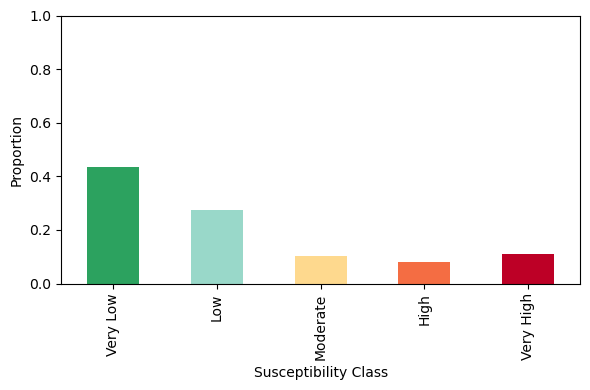

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

suscept_order = ["Very Low", "Low", "Moderate", "High", "Very High"]
colors = ["#2ca25f", "#99d8c9", "#fed98e", "#f46d43", "#bd0026"]  # match legend

bld_with_access["suscept_class"] = pd.Categorical(
    bld_with_access["suscept_class"], categories=suscept_order, ordered=True
)
props = bld_with_access["suscept_class"].value_counts(normalize=True).reindex(suscept_order)

fig, ax = plt.subplots(figsize=(6, 4))
props.plot.bar(ax=ax, color=colors)
ax.set_ylabel("Proportion")
ax.set_xlabel("Susceptibility Class")
ax.set_ylim(0, 1)
plt.tight_layout()

out_path = images_dir / "classproportion.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved plot to {out_path}")

In [30]:
import geopandas as gpd
import pandas as pd
import folium

crs_proj = "EPSG:3857"

# Project working copies
boundary_3857  = boundary.to_crs(crs_proj)
buildings_3857 = buildings.to_crs(crs_proj)
bld_3857       = bld_with_access.to_crs(crs_proj).copy()
shelters_3857  = shelters.to_crs(crs_proj).copy()

# Map center from boundary centroid (projected -> WGS84)
ctr_proj = boundary_3857.geometry.centroid
ctr_wgs = gpd.GeoSeries(ctr_proj, crs=crs_proj).to_crs("EPSG:4326")
center_lat = ctr_wgs.y.mean()
center_lon = ctr_wgs.x.mean()

# Web copies (WGS84) for Folium
boundary_web  = boundary_3857.to_crs("EPSG:4326")
buildings_web = buildings_3857.to_crs("EPSG:4326")
bld_web       = bld_3857.to_crs("EPSG:4326").copy()
shelters_web  = shelters_3857.to_crs("EPSG:4326").copy()

# Susceptibility categories/colors
suscept_order  = ["Very Low", "Low", "Moderate", "High", "Very High"]
suscept_colors = ["#2ca25f", "#99d8c9", "#fed98e", "#f46d43", "#bd0026"]
bld_web["suscept_class"] = pd.Categorical(
    bld_web["suscept_class"], categories=suscept_order, ordered=True
)

# Build map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

# Boundary
boundary_web.explore(
    name="Boundary",
    style_kwds={"color": "black", "fillColor": "none", "weight": 2},
    tiles=None, show=True, popup=False, tooltip=False, m=m,
)

# Buildings colored by susceptibility 
bld_web.explore(
    column="suscept_class",
    cmap=suscept_colors,
    categorical=True,
    legend=True,
    legend_kwds={"caption": "Flood Susceptibility"},
    tooltip=["bld_id", "median_suscept", "land_value_per_m2", "dist_to_shelter_m"],
    popup=["bld_id", "median_suscept", "land_value_per_m2", "dist_to_shelter_m"],
    name="Buildings (colored)",
    tiles=None,
    m=m,
    marker_kwds={"radius": 3},  
)

# Shelters with name on hover/click
shelters_web.explore(
    name="Shelters",
    tiles=None,
    m=m,
    marker_type="marker",
    marker_kwds={"icon": folium.Icon(color="red", icon="star")},
    tooltip=["Name"],   
    popup=["Name"],  
)

# Simple shelter legend (red star)
legend_html = """
<div style="
 position: fixed; 
 bottom: 50px; left: 50px; width: 160px; height: 40px; 
 background: white; border:2px solid #444; z-index:9999; font-size:14px;
 padding:6px;">
<b>Legend</b><br>
<span style='color:red;'>&#9733;</span> Shelter
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl().add_to(m)

m
m.save("vis/flood_buildings_map.html")
print("Saved: flood_buildings_map.html")


Saved: flood_buildings_map.html
